In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
import requests
from typing import List, Literal
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_google_genai import ChatGoogleGenerativeAI

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Get API keys from environment variables
WEATHER_API_KEY = os.getenv("WEATHER_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

In [4]:
@tool
def get_weather(query: str) -> list:
    """Search weatherapi to get the current weather"""
    endpoint = f"http://api.weatherapi.com/v1/current.json?key={WEATHER_API_KEY}&q={query}"
    response = requests.get(endpoint)
    data = response.json()

    if data.get("location"):
        return data
    else:
        return "Weather Data Not Found"
    
@tool
def search_web(query: str) -> list:
    """Search the web for a query"""
    tavily_search = TavilySearchResults(api_key=TAVILY_API_KEY, max_results=2, search_depth='advanced', max_tokens=1000)
    results = tavily_search.invoke(query)
    return results

In [5]:
llm = ChatGoogleGenerativeAI(model='gemini-1.5-flash-latest')

In [6]:
tools = [search_web, get_weather]
llm_with_tools = llm.bind_tools(tools)

In [7]:
prompt = """
    Given only the tools at your disposal, mention tool calls for the following tasks:
    Do not change the query given for any search tasks
        1. What is the current weather in Trivandrum today
        2. Can you tell me about Kerala
        3. Why is the sky blue?
    """

results = llm_with_tools.invoke(prompt)

print(results.tool_calls)

query = "What is the current weather in Trivandrum today"
response = llm.invoke(query)
print(response.content)

[{'name': 'get_weather', 'args': {'query': 'Trivandrum'}, 'id': '9a516d42-31fb-49fd-afce-c274fb302d15', 'type': 'tool_call'}, {'name': 'search_web', 'args': {'query': 'Kerala'}, 'id': '0373286c-2f8d-4f57-9d53-16ce036e8943', 'type': 'tool_call'}, {'name': 'search_web', 'args': {'query': 'Why is the sky blue?'}, 'id': 'a368aaea-7fa9-442f-b4b7-61d675dbdd27', 'type': 'tool_call'}]
I do not have access to real-time information, including live weather updates.  To get the current weather in Trivandrum (Thiruvananthapuram), India, I recommend checking a reliable weather website or app such as Google Weather, AccuWeather, or a similar service.


In [8]:
from langgraph.prebuilt import create_react_agent

# system prompt is used to inform the tools available to when to use each
system_prompt = """Act as a helpful assistant.
    Use the tools at your disposal to perform tasks as needed.
        - add: whenever user asks to add or uses + sign in a equation.
        - subtract: whenever user asks to subtract or uses - sign in a equation
    Use the tools only if you don't know the answer.
    """

# we can initialize the agent using the llama3 model, tools, and system prompt.
agent = create_react_agent(model=llm, tools=tools, prompt=system_prompt)

# Let’s query the agent to see the result.
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

inputs = {"messages": [("user", "Will it rain in Ahmedabad")]}

print_stream(agent.stream(inputs, stream_mode="values"))


================================ Human Message =================================

Will it rain in Ahmedabad
================================== Ai Message ==================================
Tool Calls:
  get_weather (b150cf07-77e4-457d-9ec1-eb14052cf0ae)
 Call ID: b150cf07-77e4-457d-9ec1-eb14052cf0ae
  Args:
    query: Ahmedabad
================================= Tool Message =================================
Name: get_weather

{"location": {"name": "Ahmedabad", "region": "Gujarat", "country": "India", "lat": 23.0333, "lon": 72.6167, "tz_id": "Asia/Kolkata", "localtime_epoch": 1758049488, "localtime": "2025-09-17 00:34"}, "current": {"last_updated_epoch": 1758049200, "last_updated": "2025-09-17 00:30", "temp_c": 27.2, "temp_f": 81.0, "is_day": 0, "condition": {"text": "Mist", "icon": "//cdn.weatherapi.com/weather/64x64/night/143.png", "code": 1030}, "wind_mph": 2.5, "wind_kph": 4.0, "wind_degree": 293, "wind_dir": "WNW", "pressure_mb": 1006.0, "pressure_in": 29.71, "precip_mm": 0.0, "pre

In [9]:
from langgraph.prebuilt import ToolNode
from langgraph.graph import StateGraph, MessagesState, START, END

In [10]:
def call_model(state: MessagesState):
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

def call_tools(state: MessagesState) -> Literal["tools", END]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END

In [12]:
tools = [search_web, get_weather]
tool_node = ToolNode(tools)

In [13]:
# initialize the workflow from StateGraph
workflow = StateGraph(MessagesState)

# add a node named LLM, with call_model function. This node uses an LLM to make decisions based on the input given
workflow.add_node("LLM", call_model)

# Our workflow starts with the LLM node
workflow.add_edge(START, "LLM")

# Add a tools node
workflow.add_node("tools", tool_node)

# Add a conditional edge from LLM to call_tools function. It can go tools node or end depending on the output of the LLM. 
workflow.add_conditional_edges("LLM", call_tools)

# tools node sends the information back to the LLM
workflow.add_edge("tools", "LLM")

agent = workflow.compile()

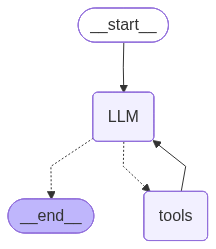

In [14]:
workflow.compile()

In [15]:
for chunk in agent.stream(
    {"messages": [("user", "Will it rain in Trivandrum today?")]},
    stream_mode="values",):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Will it rain in Trivandrum today?
================================== Ai Message ==================================
Tool Calls:
  get_weather (f00dc557-edfa-46be-918b-ac51448032c0)
 Call ID: f00dc557-edfa-46be-918b-ac51448032c0
  Args:
    query: Trivandrum
================================= Tool Message =================================
Name: get_weather

{"location": {"name": "Trivandrum", "region": "Kerala", "country": "India", "lat": 8.5069, "lon": 76.9569, "tz_id": "Asia/Kolkata", "localtime_epoch": 1758049217, "localtime": "2025-09-17 00:30"}, "current": {"last_updated_epoch": 1758049200, "last_updated": "2025-09-17 00:30", "temp_c": 27.2, "temp_f": 81.0, "is_day": 0, "condition": {"text": "Mist", "icon": "//cdn.weatherapi.com/weather/64x64/night/143.png", "code": 1030}, "wind_mph": 7.6, "wind_kph": 12.2, "wind_degree": 337, "wind_dir": "NNW", "pressure_mb": 1009.0, "pressure_in": 29.8, "precip_mm": 0